In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initial data review and cleaning

## Import the CSVs and combine the dataframes

In [2]:
csv_files = ["AW18 W3 POST.csv",
             "AW19 W3 POST.csv",
             "AW20 W2 POST.csv",
             "SS18 W27 POST.csv",
             "SS19 W27 POST.csv",
             "SS21 W27 POST.csv"]

In [3]:
dfs = []
for csv in csv_files:
    # Read DF from CSV file
    add_df = pd.read_csv(f"../raw_data/{csv}")
    
    # Clean up and replace column names for each DF
    renamed_columns = []
    columns = list(add_df.columns)
    for c in columns:
        c = c.lower()
        c = c.replace("sem","")
        c = c.replace("\n","")
        c = c.replace("\r","")
        c = c.replace("+","")
        c = c.replace(".","")
        c = c.replace("-","_")
        c = c.replace(" ","_")
        c = c.replace("é","e")
        c = c.replace("è","e")
        renamed_columns.append(c)
    columns_dict = {c:r for c,r in zip(columns,renamed_columns)}
    add_df.rename(columns=columns_dict, inplace=True)
    
    # Drop the last row of the DF
    add_df.drop(add_df.tail(1).index, inplace = True)
 
    # Drop columns that are duplicated
    add_df.drop(columns=["tx_ecouln","defilementn"], errors = "ignore", inplace = True)
    
    # Add to list of DFs to concatenate
    dfs.append(add_df)

In [4]:
data = pd.concat(dfs)

In [5]:
data.reset_index(inplace = True)

## Feature cleaning functions

### Fix comma decimal values

There are some features that use French style decimalisation. These commas need to be changed to full stops in order to convert columns to numeric dtype.

In [6]:
def replace_commas(text):
    text = str(text).replace(",",".")
    return text

### Remove commas

Several other numeric features contain commas as a place separator, also preventing conversion to numeric dtype. This function will remove the commas and strip any whitespace.

In [7]:
def remove_comma(text):
    text = str(text).replace(",","").strip()
    return text

### Change dashes to np.nan

The dataset contains quite a few rows were a dash ("-") has been added instead of a null value. Some of these may be imputable, but at this stage it these will be converted to np.nan to allow dtype conversion. They can be dropped or imputed during the next stages of analysis.

In [8]:
def make_dash_null(text):
    return np.nan if text == "-" else text

### Remove currency symbols

Several numeric features contain the symbol for EUR (€), preventing conversion to numeric dtype. This function will remove the symbol and strip any whitespace.

In [9]:
def remove_euro(text):
    text = str(text).replace("€","").strip()
    return text

### Remove percentage symbol

Some percentage values have a percent symbol hard coded in as a string, preventing conversion to numeric. This function will remove the symbol and strip any whitespace.

In [10]:
def remove_percent(text):
    text = str(text).replace("%","").strip()
    return text

## Initial Feature Review

### code_op_com

Product codes. Not valuable as an input feature. Drop from the dataframe.

In [11]:
columns_to_drop = ["code_op_com"]

### libelle_op_com

Year and season of the product. Inconsistent naming, so it's likely best to drop.

In [12]:
data.libelle_op_com.nunique()

78

In [13]:
columns_to_drop.append("libelle_op_com")

### vitrine_collection

Window display details. Inconsistent strings of text. Best to drop

In [14]:
data.vitrine_collection.nunique()

950

In [15]:
columns_to_drop.append("vitrine_collection")

### cible

"Target" - categorical feature split between baby, child, and adult. Null values to impute or drop.

In [16]:
data.cible.unique()

array(['2-ENFANT', '3-ADULTE', '1-BEBE', '-'], dtype=object)

In [17]:
data.cible.value_counts()

1-BEBE      5555
2-ENFANT    5194
3-ADULTE    2898
-             26
Name: cible, dtype: int64

### sous_cible

"Sub-target" category split into more granular items. May be worth encoding, but might also be too noisy.

In [18]:
data.sous_cible.unique()

array(['PETIT', 'FEMME', 'BEBE Debout', 'BEBE Couché', 'GRAND', 'HOMME'],
      dtype=object)

In [19]:
data.sous_cible.value_counts()

PETIT          4757
BEBE Debout    4109
FEMME          2608
BEBE Couché    1446
GRAND           463
HOMME           290
Name: sous_cible, dtype: int64

### sexe

Gender of the product - male/female/unisex. Relatively balanced categorical feature

In [20]:
data.sexe.unique()

array(['MA', 'FE', 'MI'], dtype=object)

In [21]:
data.sexe.value_counts()

FE    5604
MI    4769
MA    3300
Name: sexe, dtype: int64

### categorie

Categorical feature - apparel vertical. Potentially some imbalanced categories.

In [22]:
data.categorie.unique()

array(['JOUR', 'NUIT', 'SS VET', 'AISV', 'PUERICULTURE', 'ACCESSOIRES',
       'CHAUSSURES'], dtype=object)

In [23]:
data.categorie.value_counts()

JOUR            4957
SS VET          2404
AISV            2149
NUIT            2028
ACCESSOIRES     1840
PUERICULTURE     265
CHAUSSURES        30
Name: categorie, dtype: int64

### famille

More granular categorisation of products within their vertical. Highly variable text strings. Likely to drop.

In [24]:
data.famille.nunique()

77

In [25]:
columns_to_drop.append("famille")

### sous_famille

More granular categorisation of products within their family. Highly variable text strings. Likely to drop.

In [26]:
data.sous_famille.nunique()

183

In [27]:
columns_to_drop.append("sous_famille")

### macro_categorie

"Macro-category" - a combination of gender and category. May be colinear with other features, or a potential candidate for engineering a day/night feature.

In [28]:
data.macro_categorie.unique()

array(['Enfant Jour', 'Adulte Jour', 'Bébé Debout', 'Enfant Nuit',
       'Bébé Nuit', 'Enfant Sous-Vêt', 'Bébé couché', 'Adulte T-Shirt',
       'Bébé Sous-Vêt', 'Adulte Sous-Vêt'], dtype=object)

### nom_ref

Product name or reference. Not very useful as a learning feature, but can be used for frontend.

In [29]:
data.nom_ref.nunique()

5113

### refcol

Numeric reference to the product. Not likely to be significant. Add to drop list.

In [30]:
columns_to_drop.append("refcol")

### lib_refcol

Product text reference, typically a name and colour. Highly variable text field. Add to drop list.

In [31]:
data.lib_refcol

0        PARKA               CAPECO
1        CIRE                MARS [
2        COUPE VENT REVER    OGRE [
3         COUPE-VENT REVER.   JAUNE
4        Duffle coat         SMOKIN
                    ...            
13668          CHEMISE A BRE CITY C
13669          PYJACOURT     FLE/GR
13670          ECHARPE       MAR/SM
13671          COMBINAISON L MAR/TE
13672          MARINIERE     MAR/SM
Name: lib_refcol, Length: 13673, dtype: object

In [32]:
columns_to_drop.append("lib_refcol")

### coloris

The product colour(s). May be useful as an encoded categorical feature, but there are a lot of values.

In [33]:
data.coloris.value_counts().head(10)

varian    2113
SMOKIN    1137
MAR/MU     817
MARSHM     681
ECUME      546
SMO/MA     364
MAR/SM     316
TERKUI     226
NOIR [     224
JAUNE      215
Name: coloris, dtype: int64

### matiere

Product material. Similar to Coloris. May be usedful as a categorical feature, but would be difficult to encode so many unique values. 

In [34]:
data.matiere.value_counts()

COTE 1/1           3215
Côte 1/1           2515
AUTRES              915
JERSEY              852
Jersey              772
                   ... 
INTERL.GRAT.          1
BOU.EP.GRATTEE        1
Chambray              1
INTERLOCK DFACE       1
JERSEY GRAT.          1
Name: matiere, Length: 93, dtype: int64

### saisonnalite

Seasonality categorical feature - may be useful and seems easy to encode.

In [35]:
data.saisonnalite.value_counts()

Reconduit    5234
Eté          3555
Hiver        3281
Permanent    1603
Name: saisonnalite, dtype: int64

### pvc_france

Product price. Needs to be cleaned and converted to numeric.

In [36]:
data.pvc_france

0          99
1         139
2         129
3        69,9
4         149
         ... 
13668    14,9
13669    22,9
13670    39,9
13671    39,9
13672    79,9
Name: pvc_france, Length: 13673, dtype: object

In [37]:
data.pvc_france = data.pvc_france.map(replace_commas)

In [38]:
data.pvc_france = data.pvc_france.map(make_dash_null)

In [39]:
data.pvc_france = pd.to_numeric(data.pvc_france, errors = "coerce")

### rang

"Rank" - numeric feature. May be useful

<AxesSubplot:ylabel='Frequency'>

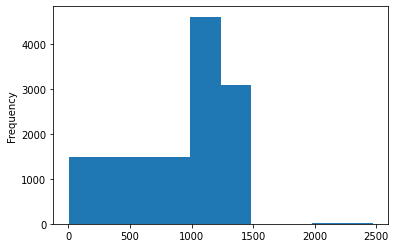

In [40]:
data.rang.plot(kind="hist")

### picto

Photo of the product. All values are nan. To drop.

In [41]:
columns_to_drop.append("picto")

### ca_net_ttcn, ca_net_ttc_1n, ca_net_ttc_2n, & ca_net_ttc_3n

Weekly sales in EUR for the current week. 1n, 2n, and 3n, are the sales for the previous weeks (1, 2, and 3 weeks ago, respectively). Some very large outliers that are likely due to totals included in each csv.

In [42]:
ca_net_weeks = ["ca_net_ttcn", "ca_net_ttc_1n", "ca_net_ttc_2n", "ca_net_ttc_3n"]

In [43]:
for ca_net in ca_net_weeks:
    data[ca_net] = data[ca_net].map(remove_euro)
    data[ca_net] = data[ca_net].map(remove_comma)
    data[ca_net] = pd.to_numeric(data[ca_net])

### qte_venduesn, qte_vendues_1n, qte_vendues_2n, &  qte_vendues_3n

Weekly unit sales. First feature is for the current week, followed by 1, 2, and 3 weeks ago respectively.

In [44]:
unit_sales = ["qte_venduesn", "qte_vendues_1n", "qte_vendues_2n", "qte_vendues_3n"]

In [45]:
for u in unit_sales:
    data[u] = data[u].map(remove_comma)
    data[u] = pd.to_numeric(data[u])

### taux_de_remisen & taux_de_remise_1n

Discount rate - one for the current week and the previous week.

In [46]:
discount_rates = ["taux_de_remisen", "taux_de_remise_1n"]

In [47]:
for dr in discount_rates:
    data[dr] = data[dr].map(remove_percent)
    data[dr] = data[dr].map(remove_comma)
    data[dr] = data[dr].map(make_dash_null)
    data[dr] = pd.to_numeric(data[dr], errors="coerce")

### stock_pdvn, stk_transitn, & stock_pdv__transit; stk_dispoentrepotn, stk_hors_dispopour_reassortn, stk_disporalcdegenn, & stk_dispopour_reassortn

Different counts of stock: stock in store (PDV), stock in transit (transit), and stock in store + in transit. Also includes warehouse stock (dispoentrepot), and three different transit from warehours features. It's likely not all of these are relevant, but there is potential for some feature engineering here as well. 

In [48]:
stocks = ["stock_pdvn", 
    "stk_transitn", 
    "stock_pdv__transit",
    "stk_dispoentrepotn", 
    "stk_hors_dispopour_reassortn", 
    "stk_disporalcdegenn", 
    "stk_dispopour_reassortn"]

In [49]:
for s in stocks:
    data[s] = data[s].map(remove_comma)
    data[s] = pd.to_numeric(data[s])

### couverturen

"Cover" rate. ie. the amount of time that the available supply of goods in a company's inventory will last given the current rate of sales.

In [50]:
data.couverturen = data.couverturen.map(remove_comma)
data.couverturen = data.couverturen.map(make_dash_null)
data.couverturen = pd.to_numeric(data.couverturen)

### defilementn

Run rate - forecast looks at how much inventory you'll probably sell over a given period. Some CSV files had multiples of this column, so it was deemed unreliable and left out.

### ca_net_ttccumuln

Cumulative year's sales in EUR.

In [51]:
data.ca_net_ttccumuln = pd.to_numeric(data.ca_net_ttccumuln.map(remove_euro).map(remove_comma))

### taux_de_remisecumuln

Cumulative discount rate

In [52]:
data.taux_de_remisecumuln = pd.to_numeric(data.taux_de_remisecumuln.map(remove_percent).map(remove_comma).map(make_dash_null))

### qte_venduescumuln

Cumulative year's unit sales

In [53]:
data.qte_venduescumuln = pd.to_numeric(data.qte_venduescumuln.map(remove_comma))

### nb_rcten_venten

Number of markets selling the product 

In [54]:
data.nb_rcten_venten.value_counts()

5     2480
7     1994
6     1795
0     1472
1     1418
8     1360
3     1325
4     1264
2      524
9       25
11      11
10       5
Name: nb_rcten_venten, dtype: int64

### nb_pdvavec_rc_en_venten

Number of stores with the product in stock.

In [55]:
data.nb_pdvavec_rc_en_venten = pd.to_numeric(data.nb_pdvavec_rc_en_venten)

### vte_moyennesrct/point_de_venten

Average unit sales per location

In [56]:
data["vte_moyennesrct/point_de_venten"] = pd.to_numeric(data["vte_moyennesrct/point_de_venten"].map(make_dash_null))

### aine_1ere_vten

Week of first sale. Determines how long a product has been sold. Will need to convert to datetime

In [57]:
data.aine_1ere_vten.map(make_dash_null)

0        2018-S29
1        2018-S29
2        2018-S42
3        2018-S34
4        2018-S36
           ...   
13668    2021-S01
13669    2021-S03
13670         NaN
13671    2021-S06
13672    2020-S53
Name: aine_1ere_vten, Length: 13673, dtype: object

### tx_ecoulcumuln

Run rate - amount of stock of the product that has been sold for the season. 100% means all stock has been sold.

In [58]:
data.tx_ecoulcumuln = pd.to_numeric(data.tx_ecoulcumuln.map(remove_percent).map(remove_comma).map(make_dash_null))

### engagement_globaln

Website engagement for the product

In [59]:
data.engagement_globaln = pd.to_numeric(data.engagement_globaln.map(remove_comma))

### tx_ecoul_sur_engtcumuln

Run rate including online sales

In [60]:
data.tx_ecoul_sur_engtcumuln = pd.to_numeric(data.tx_ecoul_sur_engtcumuln.map(remove_percent).map(remove_comma).map(make_dash_null))

### %

 The markdown selected for the sale

In [61]:
data["%"] = pd.to_numeric(data["%"].map(remove_percent))/100

## Updated DataFrame

In [62]:
data = data.drop(columns="picto")

In [63]:
data.dropna(inplace = True)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4359 entries, 0 to 11386
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            4359 non-null   int64  
 1   code_op_com                      4359 non-null   object 
 2   libelle_op_com                   4359 non-null   object 
 3   vitrine_collection               4359 non-null   object 
 4   cible                            4359 non-null   object 
 5   sous_cible                       4359 non-null   object 
 6   sexe                             4359 non-null   object 
 7   categorie                        4359 non-null   object 
 8   famille                          4359 non-null   object 
 9   sous_famille                     4359 non-null   object 
 10  macro_categorie                  4359 non-null   object 
 11  nom_ref                          4359 non-null   object 
 12  refcol             

In [65]:
columns_to_drop

['code_op_com',
 'libelle_op_com',
 'vitrine_collection',
 'famille',
 'sous_famille',
 'refcol',
 'lib_refcol',
 'picto']